# Install The Required Libraries

In [1]:
!pip install --upgrade wandb

     |████████████████████████████████| 2.0 MB 7.3 MB/s 
  Attempting uninstall: wandb
    Found existing installation: wandb 0.12.2
    Uninstalling wandb-0.12.2:
      Successfully uninstalled wandb-0.12.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
allennlp 2.7.0 requires wandb<0.13.0,>=0.10.0, but you have wandb 0.15.3 which is incompatible.


In [2]:
!pip install datasets transformers rouge-score nltk -q

In [3]:
!pip install torch==1.7.1 -q

## Imports

In [4]:
import os
import glob
import nltk
import gc
import warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import transformers
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from datasets import Dataset, load_metric
from transformers import AutoTokenizer

warnings.filterwarnings("ignore")
print(transformers.__version__)

4.5.1


## GPU Information

In [5]:
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("[INFO] training using {}".format(torch.cuda.get_device_name(0)))

[INFO] training using Tesla P100-PCIE-16GB


## Load The Data:

The data is in the form of news and summary text files for 5 categories in two separate folders: **News** and **Summary** that are in the main directory. The code below shows the process of conversion of the data to csv format where each row represents as a separate news and its corresponding summary and category.

In [6]:
os.listdir("/kaggle/input/bbc-news-summary/BBC News Summary/News Articles")
os.listdir("/kaggle/input/bbc-news-summary/BBC News Summary/Summaries")

articles_path = "/kaggle/input/bbc-news-summary/BBC News Summary/News Articles"
summaries_path = "/kaggle/input/bbc-news-summary/BBC News Summary/Summaries"
categories_list = os.listdir(articles_path)

## Read the files from file

def read_file(articles_path, summaries_path, categories_list, encoding = "ISO-8859-1"):
    articles = []
    summaries = []
    categories = []
    for category in categories_list:
        article_paths = glob.glob(os.path.join(articles_path, category, '*.txt'), recursive = True)
        summary_paths = glob.glob(os.path.join(summaries_path, category, '*.txt'), recursive = True)
        
        print(f'found {len(article_paths)} file in articles/{category} folder, {len(summary_paths)} file in summaries/{category}')
        
        if len(article_paths) != len(summary_paths):
            print("number of files is not equal")
            return 
        for file in range(len(article_paths)):
            categories.append(category)
            with open(article_paths[file], mode = 'r', encoding = encoding ) as files:
                articles.append(files.read())
                
            with open(summary_paths[file], mode = 'r', encoding = encoding) as files:
                summaries.append(files.read())
     
    print(f'total {len(articles)} file in articles folder and {len(summaries)} files in summaries folder')
    return articles, summaries, categories

In [7]:
articles, summaries, categories = read_file(articles_path, summaries_path, categories_list)

found 417 file in articles/politics folder, 417 file in summaries/politics
found 511 file in articles/sport folder, 511 file in summaries/sport
found 401 file in articles/tech folder, 401 file in summaries/tech
found 386 file in articles/entertainment folder, 386 file in summaries/entertainment
found 510 file in articles/business folder, 510 file in summaries/business
total 2225 file in articles folder and 2225 files in summaries folder


In [8]:
df = pd.DataFrame({'document': articles, 'summary': summaries,
                    'categories': categories})

df.head()

,document,summary,categories
0,Budget to set scene for election\n\nGordon Bro...,- Increase in the stamp duty threshold from Â£...,politics
1,Army chiefs in regiments decision\n\nMilitary ...,"""They are very much not for the good and will ...",politics
2,Howard denies split over ID cards\n\nMichael H...,Michael Howard has denied his shadow cabinet w...,politics
3,Observers to monitor UK election\n\nMinisters ...,The report said individual registration should...,politics
4,Kilroy names election seat target\n\nEx-chat s...,"UKIP's leader, Roger Knapman, has said he is g...",politics


In [9]:
df.isnull().sum()

document      0
summary       0
categories    0
dtype: int64

In [10]:
df['articles_length'] = df['document'].apply(lambda x : len(x.split()))
df['summaries_length'] = df['summary'].apply(lambda x : len(x.split()))

In [11]:
df[df['categories']=='sport']['articles_length'].describe()

count     511.000000
mean      329.262231
std       187.963267
min       114.000000
25%       204.000000
50%       288.000000
75%       409.500000
max      1662.000000
Name: articles_length, dtype: float64

## Mean length of articles and summaries per category

In [12]:
category_length = df.groupby('categories').agg({'articles_length':'mean', 'summaries_length':'mean'})
category_length

,articles_length,summaries_length
categories,,
business,328.880392,139.929412
entertainment,330.621762,144.049223
politics,453.973621,195.709832
sport,329.262231,143.187867
tech,502.695761,213.837905


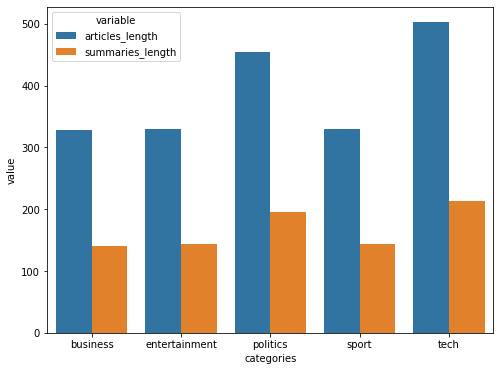

In [13]:
data_new = pd.melt(category_length, ignore_index= False)
plt.figure(figsize=(8,6))
sns.barplot(x = data_new.index, y = 'value', hue = 'variable', data = data_new)
plt.show()

In [14]:
pd.melt(category_length, ignore_index = False).groupby('variable').mean()

,value
variable,
articles_length,389.086753
summaries_length,167.342848


## Data Preprocessing

In [15]:
df['document']= df['document'].apply(lambda x: x.lower())
df['summary'] = df['summary'].apply(lambda x: x.lower())

In [16]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2225 entries, 0 to 2224
Data columns (total 5 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   document          2225 non-null   object
 1   summary           2225 non-null   object
 2   categories        2225 non-null   object
 3   articles_length   2225 non-null   int64 
 4   summaries_length  2225 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 87.0+ KB


In [17]:
pd.set_option('display.max_colwidth',None)
df.head(1)

,document,summary,categories,articles_length,summaries_length
0,"budget to set scene for election\n\ngordon brown will seek to put the economy at the centre of labour's bid for a third term in power when he delivers his ninth budget at 1230 gmt. he is expected to stress the importance of continued economic stability, with low unemployment and interest rates. the chancellor is expected to freeze petrol duty and raise the stamp duty threshold from â£60,000. but the conservatives and lib dems insist voters face higher taxes and more means-testing under labour.\n\ntreasury officials have said there will not be a pre-election giveaway, but mr brown is thought to have about â£2bn to spare.\n\n- increase in the stamp duty threshold from â£60,000 \n - a freeze on petrol duty \n - an extension of tax credit scheme for poorer families \n - possible help for pensioners the stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos. ten years ago, buyers had a much greater chance of avoiding stamp duty, with close to half a million properties, in england and wales alone, selling for less than â£60,000. since then, average uk property prices have more than doubled while the starting threshold for stamp duty has not increased. tax credits as a result, the number of properties incurring stamp duty has rocketed as has the government's tax take. the liberal democrats unveiled their own proposals to raise the stamp duty threshold to â£150,000 in february.\n\nthe tories are also thought likely to propose increased thresholds, with shadow chancellor oliver letwin branding stamp duty a ""classic labour stealth tax"". the tories say whatever the chancellor gives away will be clawed back in higher taxes if labour is returned to power. shadow treasury chief secretary george osborne said: ""everyone who looks at the british economy at the moment says there has been a sharp deterioration in the public finances, that there is a black hole,"" he said. ""if labour is elected there will be a very substantial tax increase in the budget after the election, of the order of around â£10bn.""\n\nbut mr brown's former advisor ed balls, now a parliamentary hopeful, said an examination of tory plans for the economy showed there would be a â£35bn difference in investment by the end of the next parliament between the two main parties. he added: ""i don't accept there is any need for any changes to the plans we have set out to meet our spending commitments.""\n\nfor the lib dems david laws said: ""the chancellor will no doubt tell us today how wonderfully the economy is doing,"" he said. ""but a lot of that is built on an increase in personal and consumer debt over the last few years - that makes the economy quite vulnerable potentially if interest rates ever do have to go up in a significant way."" snp leader alex salmond said his party would introduce a â£2,000 grant for first time buyers, reduce corporation tax and introduce a citizens pension free from means testing. plaid cymru's economics spokesman adam price said he wanted help to get people on the housing ladder and an increase in the minimum wage to â£5.60 an hour.\n","- increase in the stamp duty threshold from â£60,000 - a freeze on petrol duty - an extension of tax credit scheme for poorer families - possible help for pensioners the stamp duty threshold rise is intended to help first time buyers - a likely theme of all three of the main parties' general election manifestos.the chancellor is expected to freeze petrol duty and raise the stamp duty threshold from â£60,000.the tories are also thought likely to propose increased thresholds, with shadow chancellor oliver letwin branding stamp duty a ""classic labour stealth tax"".tax credits as a result, the number of properties incurring stamp duty has rocketed as has the government's tax take.since then, average uk property prices have more than doubled while the starting thres

## Split the dataset into train, validation, and test set

As a common practice, we split the dataset into:

* Training set: Data used for training the model parameters.
* Validation set: Data used for hyperparameter tuning or early stopping to avoid overfitting.
* Test set: Data used for checking what performance we can expect on new data.

The split was stratified on the "category" column, so that the distribution of the categories is similar across the three sets.

In [18]:
# Shuffle the dataset to ensure randomization
data = shuffle(df, random_state=4)
train_ratio = 0.6
valid_ratio = 0.2
test_ratio = 0.2
stratify_column='categories'


# Split into train and remaining
train, remaining_data = train_test_split(data, test_size=(1 - train_ratio), stratify=data[stratify_column], random_state=42)

# Split the remaining into validation and test
valid, test = train_test_split(remaining_data, test_size=test_ratio / (valid_ratio + test_ratio), stratify=remaining_data[stratify_column], random_state=42)

In [19]:
train.shape, valid.shape,test.shape

((1335, 5), (445, 5), (445, 5))

## Preprocess the dataset for BART

The model we chose for our task is BART

As for every transformer model, we need first to tokenize the textual training data: the news content and the summary.
Let’s instantiate the tokenizer of the BART model.

In [20]:
model_checkpoint ='facebook/bart-large'
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)
tokenizer.padding_side == "right"

Downloading:   0%|          | 0.00/1.63k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/899k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/456k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

True

Then, we define the `preprocess_data` function that takes a batch of samples as inputs and outputs a dictionary of new features to add to the samples. The preprocess_data function does the following:

* Prepend the text “summarize: “ to each news text
* Apply the BART tokenizer to the news text, creating the `model_inputs` object. This object is a dictionary containing, for each news, an input_ids and an attention_mask arrays containing the token ids and the attention masks respectively.
* Apply the BART tokenizer to the news summaries, creating the labels object. Also in this case, this object is a dictionary containing, for each news, an input_ids and an attention_mask arrays containing the token ids and the attention masks respectively. Note that this step is done inside the `tokenizer.as_target_tokenizer()` context manager: this is usually done because there are text2text tasks where inputs and labels must be tokenized with different tokenizers (e.g. when translating between two languages, where each language has its own tokenizer). As far as I know, for text summarization the labels are tokenized with the same tokenizer as the inputs, thus the context manager is optional.
* Return a dictionary containing the token ids and attention masks of the inputs, and the token ids of the labels.

In [21]:
max_input_length = 512
max_target_length = 128
def preprocess_function(examples):
    inputs = ['summarize:' + doc for doc in examples["document"]]
    model_inputs = tokenizer(inputs, max_length=max_input_length, truncation=True,padding='max_length')

    # Setup the tokenizer for targets
    with tokenizer.as_target_tokenizer():
        labels = tokenizer(examples["summary"], max_length=max_target_length, truncation=True)

    model_inputs["labels"] = labels["input_ids"]
    return model_inputs

> Note that we are truncating the inputs at 512 tokens. While BART can manage longer inputs, the memory requirements grow quadratically with the size of the inputs, and that was the maximum size that I could use in my Kaggle session.

The `preprocess_data` function can be applied to all the datasets with the map method.



In [22]:
train = Dataset.from_pandas(train)
valid = Dataset.from_pandas(valid)
tokenized_train = train.map(preprocess_function, batched=True)
tokenized_valid = valid.map(preprocess_function, batched=True)

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [23]:
assert isinstance(tokenizer, transformers.PreTrainedTokenizerFast)

## Preparing the Hugging Face trainer
We can now fine-tune BART with our preprocessed data! Let’s import some necessary classes to train text2text models and our load our model BART

In [24]:
from transformers import AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
model = AutoModelForSeq2SeqLM.from_pretrained(model_checkpoint)

Downloading:   0%|          | 0.00/1.02G [00:00<?, ?B/s]

Next, we instantiate a `DataCollatorForSeq2Seq` object using the tokenizer. Data collators are objects that form a batch by using a list of dataset elements as input and, in some cases, applying some processing. In this case, all the inputs and labels in the same batch will be padded to their respective maximum length in the batch. Padding of the inputs is done with the usual *[PAD]* token, whereas the padding of the labels is done with a token with id -100, which is a special token automatically ignored by PyTorch loss functions.

In [25]:
data_collator = DataCollatorForSeq2Seq(tokenizer, model=model)

Next, we download the ROUGE code using the `load_metric` function from the `datasets` library, thus instantiating a metric object. This object can then be used to compute its metrics using predictions and reference labels.

In [26]:
metric = load_metric("rouge")

Downloading:   0%|          | 0.00/2.17k [00:00<?, ?B/s]

The metric object must then be called inside a `compute_metrics` function which takes a tuple of predictions and reference labels as input, and outputs a dictionary of metrics computed over the inputs. Specifically, the `compute_metrics` function does the following:

* Decode the predictions (i.e. from token ids to words).
* Decode the labels after substituting the *-100* token id with the *[PAD]* token id.
* Compute ROUGE scores using the decoded predictions and labels, and select only a subset of these metrics.
* Return a dictionary whose keys are the names of the metrics and the values are the metric values.


In [27]:
def compute_metrics(eval_pred):
    predictions, labels = eval_pred
    decoded_preds = tokenizer.batch_decode(predictions, skip_special_tokens=True)
    # Replace -100 in the labels as we can't decode them.
    labels = np.where(labels != -100, labels, tokenizer.pad_token_id)
    decoded_labels = tokenizer.batch_decode(labels, skip_special_tokens=True)
    
    # Rouge expects a newline after each sentence
    decoded_preds = ["\n".join(nltk.sent_tokenize(pred.strip())) for pred in decoded_preds]
    decoded_labels = ["\n".join(nltk.sent_tokenize(label.strip())) for label in decoded_labels]
    
    result = metric.compute(predictions=decoded_preds, references=decoded_labels, use_stemmer=True)
    # Extract a few results
    result = {key: value.mid.fmeasure * 100 for key, value in result.items()}    
    return {k: round(v, 4) for k, v in result.items()}

We create a `Seq2SeqTrainingArguments` object containing several training parameters that will define how the model is trained. 
Here is the explanation of some unusual parameters passed to the Seq2SeqTrainingArguments object:

* `predict_with_generate`: Must be set to True to calculate generative metrics such as ROUGE and BLEU.
* `fp16`: Whether to use fp16 16-bit (mixed) precision training instead of 32-bit training. Makes training faster.
* `report_to`: List of integrations to write logs to,W use weights and biases for our experiment tracking.

In [28]:
batch_size=4
model_name = model_checkpoint.split("/")[-1]
args = Seq2SeqTrainingArguments(
    f"{model_name}-finetuned-newsarticles",
    evaluation_strategy = "epoch",
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    gradient_accumulation_steps=4,
    weight_decay=0.01,
    logging_steps=50,
    save_total_limit=3,
    num_train_epochs=7,
    predict_with_generate=True,
    fp16=False,
    report_to="wandb"
)

In [29]:
gc.collect()
torch.cuda.empty_cache()

We finally create a Seq2SeqTrainer passing all the objects that we have just defined: the training arguments, the training and evaluation data,the model, the data collator, the tokenizer, and the `compute_metrics`

In [30]:
trainer = Seq2SeqTrainer(
    model,
    args,
    train_dataset=tokenized_train,
    eval_dataset=tokenized_valid,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


## Weights and Biases Integration

Before we start training. we login to weights and biases account through the api key added in the user secrets in the Add-ons section.
This helps us to log and monitor the training in progress.

In [31]:
import wandb
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
api_key = user_secrets.get_secret("wandb_api")
wandb.login(key=api_key)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


wandb: W&B API key is configured. Use `wandb login --relogin` to force relogin
wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

## Fine-tune BART

Last, we start the fine-tuning with the train method.



In [32]:
trainer.train()

wandb: Currently logged in as: shreyasajal. Use `wandb login --relogin` to force relogin
wandb: Tracking run with wandb version 0.15.3
wandb: Run data is saved locally in /kaggle/working/wandb/run-20230525_152406-ohz4je68
wandb: Run `wandb offline` to turn off syncing.
wandb: Syncing run bart-large-finetuned-newsarticles
wandb: ⭐️ View project at https://wandb.ai/shreyasajal/huggingface
wandb: 🚀 View run at https://wandb.ai/shreyasajal/huggingface/runs/ohz4je68


Epoch,Training Loss,Validation Loss,Rouge1,Rouge2,Rougel,Rougelsum,Runtime,Samples Per Second
0,0.591600,0.420519,19.664000,15.617100,18.637900,18.792300,174.002100,2.557000
1,0.424200,0.390998,20.741200,17.337500,20.007400,20.091800,174.352100,2.552000
2,0.388400,0.381323,21.364900,18.453600,20.842700,20.921700,174.154300,2.555000
3,0.330000,0.383105,21.743000,18.732100,21.167000,21.250100,173.521000,2.565000
4,0.295300,0.372963,21.875100,19.003500,21.333300,21.419900,173.350400,2.567000
5,0.299600,0.379148,21.681900,18.719700,21.126600,21.197500,173.698300,2.562000
6,0.266900,0.382956,21.732200,18.810200,21.198600,21.266600,173.394700,2.566000


TrainOutput(global_step=581, training_loss=0.36240531983761287, metrics={'train_runtime': 2925.7544, 'train_samples_per_second': 0.199, 'total_flos': 1.4568747023941632e+16, 'epoch': 6.99, 'init_mem_cpu_alloc_delta': 1140477952, 'init_mem_gpu_alloc_delta': 1625367040, 'init_mem_cpu_peaked_delta': 999817216, 'init_mem_gpu_peaked_delta': 0, 'train_mem_cpu_alloc_delta': 32505856, 'train_mem_gpu_alloc_delta': 4875538944, 'train_mem_cpu_peaked_delta': 621465600, 'train_mem_gpu_peaked_delta': 6381357056})

# Evaluation On Validation Set


In [33]:
valid = valid.map(
                preprocess_function,
                batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [34]:
predict_results = trainer.predict(
            valid,max_length=250, num_beams=3)

In [35]:
metrics = predict_results.metrics

In [36]:
metrics

{'eval_loss': 0.38295605778694153,
 'eval_rouge1': 64.9158,
 'eval_rouge2': 54.0284,
 'eval_rougeL': 48.9985,
 'eval_rougeLsum': 52.3078,
 'eval_runtime': 971.611,
 'eval_samples_per_second': 0.458,
 'test_mem_cpu_alloc_delta': -5853184,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 5595136,
 'test_mem_gpu_peaked_delta': 1388618240}

# Evaluation On Test Set

In [37]:
eval_dataset = Dataset.from_pandas(test)

In [38]:
eval_dataset = eval_dataset.map(
                preprocess_function,
                batched=True)

  0%|          | 0/1 [00:00<?, ?ba/s]

In [39]:
predict_results = trainer.predict(
            eval_dataset,max_length=250, num_beams=3)

In [40]:
metrics = predict_results.metrics

In [41]:
metrics

{'eval_loss': 0.4582759439945221,
 'eval_rouge1': 63.3473,
 'eval_rouge2': 52.1871,
 'eval_rougeL': 47.8493,
 'eval_rougeLsum': 50.9421,
 'eval_runtime': 982.1604,
 'eval_samples_per_second': 0.453,
 'test_mem_cpu_alloc_delta': -8105984,
 'test_mem_gpu_alloc_delta': 0,
 'test_mem_cpu_peaked_delta': 8105984,
 'test_mem_gpu_peaked_delta': 1417019392}

# Predictions on Test


In [42]:
predictions = tokenizer.batch_decode(predict_results.predictions, skip_special_tokens=True, clean_up_tokenization_spaces=True)
predictions = [pred.strip() for pred in predictions]

In [43]:
predictions[5:6]

['a us defence and telecommunications company has agreed to pay $28.5m after admitting bribery in the west african state of benin.the sec had accused titan of illegally paying $2.1m to an unnamed agent in benin claiming ties with president kerekou.the titan corporation was accused of funnelling more than $2m into the 2001 re-election campaign of president mathieu']

In [44]:
test['summary'][5:6]

2079    a us defence and telecommunications company has agreed to pay $28.5m after admitting bribery in the west african state of benin.the titan corporation was accused of funnelling more than $2m into the 2001 re-election campaign of president mathieu kerekou.the sec had accused titan of illegally paying $2.1m to an unnamed agent in benin claiming ties with president kerekou.at the time, titan was trying to get a higher price for a telecommunications project in benin.titan, a california-based company, pleaded guilty to falsifying its accounts and violating us anti-bribery laws.
Name: summary, dtype: object

In [45]:
pd.DataFrame({'references': test['summary'],'candidates':predictions}).to_csv('bertscore_data_bart-large.csv')

# Function for Inference

In [46]:
model=trainer.model

In [47]:
def inference_function(input_text):
    text='summarize:'+ input_text
    inputs = tokenizer(text, return_tensors="pt").input_ids.to(DEVICE)
    outputs = model.generate(inputs, max_length=250, num_beams=3, do_sample=False)
    summary=tokenizer.decode(outputs[0], skip_special_tokens=True)
    return summary

In [48]:
summary=inference_function(test['document'][2079])

In [49]:
summary

'a us defence and telecommunications company has agreed to pay $28.5m after admitting bribery in the west african state of benin.the sec had accused titan of illegally paying $2.1m to an unnamed agent in benin claiming ties with president kerekou.the titan corporation was accused of funnelling more than $2m into the 2001 re-election campaign of president mathieu'

In [50]:
test['summary'][2079]

'a us defence and telecommunications company has agreed to pay $28.5m after admitting bribery in the west african state of benin.the titan corporation was accused of funnelling more than $2m into the 2001 re-election campaign of president mathieu kerekou.the sec had accused titan of illegally paying $2.1m to an unnamed agent in benin claiming ties with president kerekou.at the time, titan was trying to get a higher price for a telecommunications project in benin.titan, a california-based company, pleaded guilty to falsifying its accounts and violating us anti-bribery laws.'